# Load packages

In [1]:
# Basics
import numpy as np
import pandas as pd
import itertools

# Viz
import matplotlib.pylab as plt

%matplotlib inline 


# Image related
from cv2 import resize, imread 

# Viz

# ML
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedGroupKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, log_loss, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

## DL
import keras
from keras import backend as k
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D


# Load data files

In [2]:
X = np.load("../Data/X.npy")
y = np.load("../Data/Y.npy")

# Exploratory Data Analysis

## Basic information

In [3]:
def describeData(a, b):
    print(f"Total number of images: {len(a)}")
    print(f"Number of IDC(-) images: {np.sum(b==0)}")
    print(f"Number of IDC(+) images: {np.sum(b)}")
    print(f"Percentage of positive images: {100*np.mean(b):.2f}%")
    print(f"Image shape (Width, Height, Channels): {a[0].shape}")


In [4]:
describeData(X, y)

Total number of images: 5547
Number of IDC(-) images: 2759
Number of IDC(+) images: 2788
Percentage of positive images: 50.26%
Image shape (Width, Height, Channels): (50, 50, 3)


## Visualize the images

In [5]:
imgs0 = X[y==0]
imgs1 = X[y==1]

In [6]:
def plotSamples(a, b):
    """
    Plot a bunch of numpy arrays sorted by label
    """

    for row in range(3):
        plt.figure(figsize=(20, 10))
        for col in range(3):
            plt.subplot(1, 6, col+1)
            plt.title("IDC (-)")
            plt.imshow(a[row+col])
            plt.axis('off')

            plt.subplot(1, 6, col+4)
            plt.title("IDC (+)")
            plt.imshow(b[row+col])
            plt.axis('off')


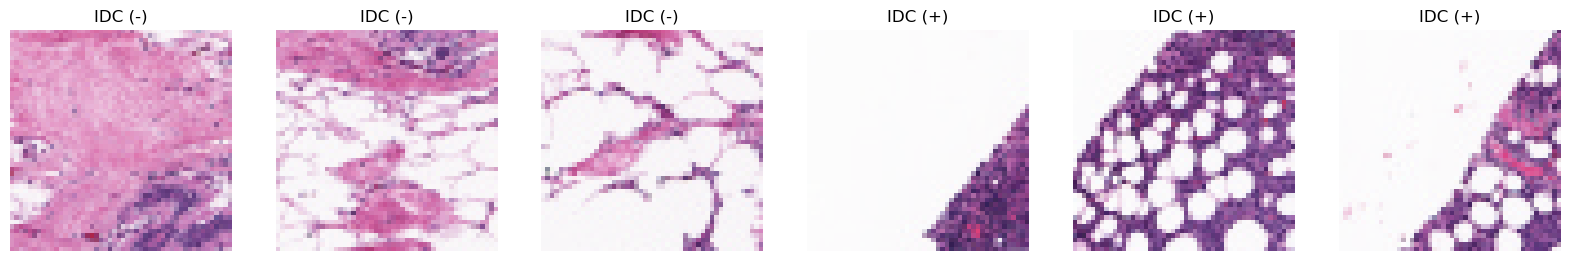

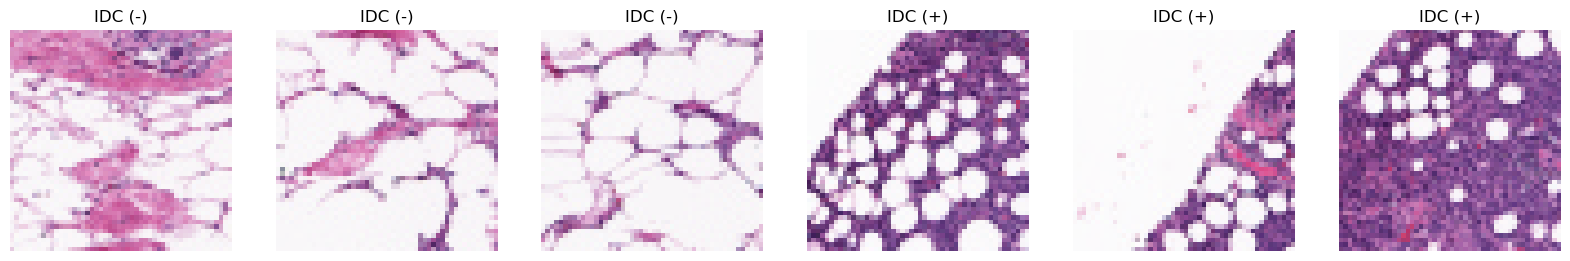

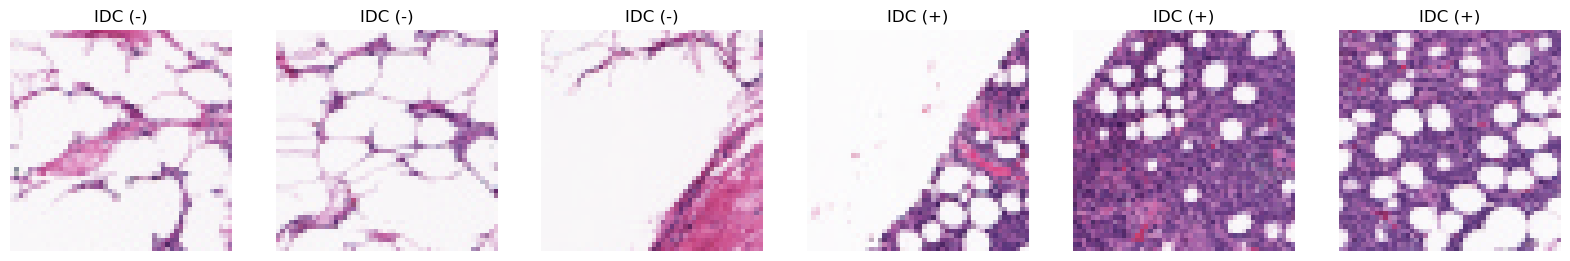

In [7]:
plotSamples(imgs0, imgs1)

In [8]:
def plotHistogram(a, index_):
    """
    Plot histogram of RGB Pixel Intensities
    """

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(a[index_])
    plt.axis('off')
    plt.title('IDC (+)' if y[index_] else 'IDC (-)')

    histo = plt.subplot(1, 2, 2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30

    # lw: linewidth
    plt.hist(a[index_, :, :, 0].flatten(), bins=n_bins, lw=0, color='r', alpha=0.5)
    plt.hist(a[index_, :, :, 1].flatten(), bins=n_bins, lw=0, color='r', alpha=0.5)
    plt.hist(a[index_, :, :, 2].flatten(), bins=n_bins, lw=0, color='b', alpha=0.5)



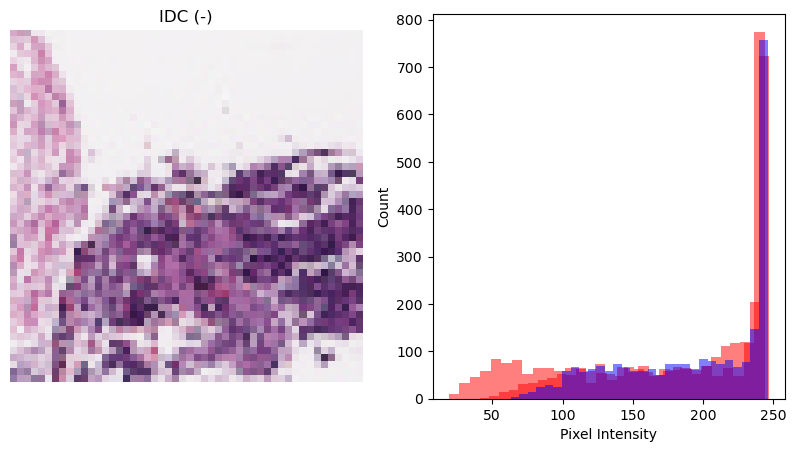

In [9]:
plotHistogram(X, 100)

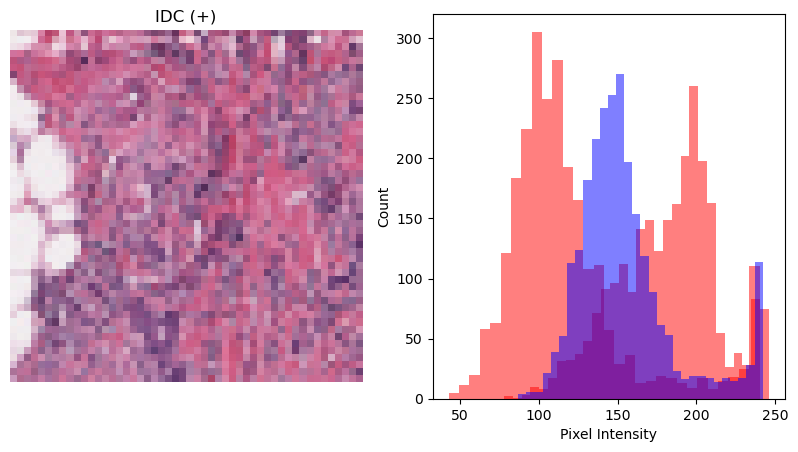

In [10]:
plotHistogram(X, 5000)

# Data preprocessing

## Scale
The data is scaled from 0 to 256. To make the data compatible with a wide variety of different classification algorithms, the data will be scaled from 0 to 1.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

In [18]:
X_train.shape

(4437, 50, 50, 3)

In [19]:
X_test.shape

(1110, 50, 50, 3)

In [20]:
# Reduce Sample Size for DeBugging
X_train = X_train[0:30000] 
y_train = y_train[0:30000]
X_test = X_test[0:30000] 
y_test = y_test[0:30000]

# Normalize the data
X_train = X_train / 256.0
X_test = X_test / 256.0

print("Training Data Shape:", X_train.shape, X_train.shape)
print("Testing Data Shape:", X_test.shape, X_test.shape)

Training Data Shape: (4437, 50, 50, 3) (4437, 50, 50, 3)
Testing Data Shape: (1110, 50, 50, 3) (1110, 50, 50, 3)


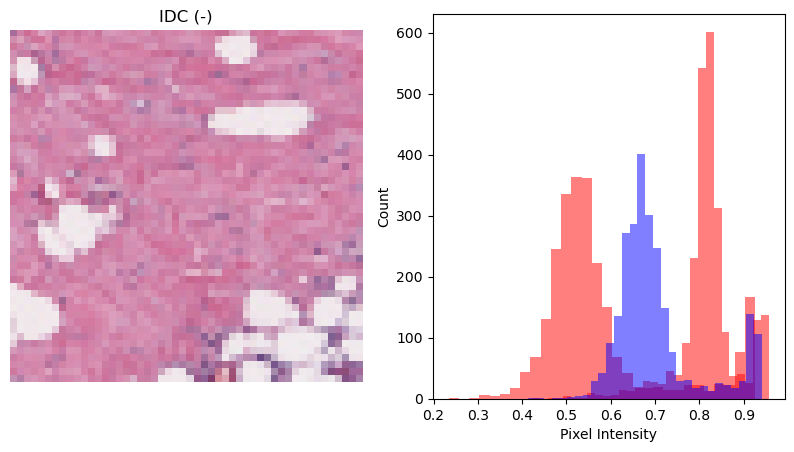

In [21]:
plotHistogram(X_train, 50)

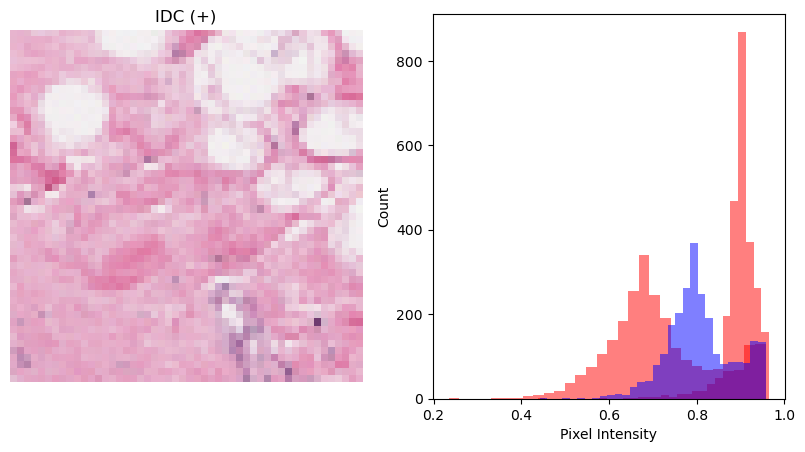

In [22]:
plotHistogram(X_train, 3499)

# Modeling

## Evaluate Classification Algorithms

### Prepare data - Flat the date into one dimention

In [23]:
# Make Data 1D for compatability with standard classifiers
X_trainShape = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]
X_testShape = X_test.shape[1] * X_test.shape[2] * X_train.shape[3]

In [24]:
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)

In [25]:
X_train.shape

(4437, 50, 50, 3)

In [26]:
X_trainFlat.shape

(4437, 7500)

In [27]:
X_test.shape

(1110, 50, 50, 3)

In [28]:
X_testFlat.shape

(1110, 7500)

### Compare performance of different classifiers

In [29]:
# Compare Performance of Classification Algorithms
def compareABunchOfDifferentModelsAccuracy(a,b,c,d):
    """
    compare performance of classifiers on X_train, X_test, Y_train, Y_test
    http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score
    http://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score
    """    
    print('')
    print('Compare Multiple Classifiers:')
    print('')
    print('K-Fold Cross-Validation Accuracy:')
    print('')
    models = []
    models.append(('LR', LogisticRegression(max_iter=10000)))
    models.append(('RF', RandomForestClassifier()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('SVM', SVC(max_iter=10000)))
    models.append(('LSVM', LinearSVC()))
    models.append(('GNB', GaussianNB()))
    models.append(('DTC', DecisionTreeClassifier()))
    #models.append(('GBC', GradientBoostingClassifier()))
    #models.append(('LDA', LinearDiscriminantAnalysis()))       
    resultsAccuracy = []
    names = []
    for name, model in models:
        model.fit(a, b)
        kfold = model_selection.KFold(n_splits=10)
        accuracy_results = model_selection.cross_val_score(model, c, d, cv=kfold, scoring='accuracy')
        resultsAccuracy.append(accuracy_results)
        names.append(name)
        accuracyMessage = "%s: %f (%f)" % (name, accuracy_results.mean(), accuracy_results.std())
        print(accuracyMessage)  
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison: Accuracy')
    ax = fig.add_subplot(111)
    plt.boxplot(resultsAccuracy)
    ax.set_xticklabels(names)
    ax.set_ylabel('Cross-Validation: Accuracy Score')
    plt.show()


    # Print each abbreviation used in the previous function (e.g. LR = Logistic Regression)

    print('')
    print('LR = LogisticRegression')
    print('RF = RandomForestClassifier')
    print('KNN = KNeighborsClassifier')
    print('SVM = Support Vector Machine SVC')
    print('LSVM = LinearSVC')
    print('GNB = GaussianNB')
    print('DTC = DecisionTreeClassifier')
    #print('GBC = GradientBoostingClassifier')
    #print('LDA = LinearDiscriminantAnalysis')
    print('')


    return


Compare Multiple Classifiers:

K-Fold Cross-Validation Accuracy:

LR: 0.715315 (0.040531)
RF: 0.765766 (0.040490)
KNN: 0.737838 (0.033089)
SVM: 0.772973 (0.036216)


/opt/anaconda3/envs/CNN/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/CNN/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/CNN/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/CNN/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/CNN/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/CNN/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: Convergenc

LSVM: 0.681081 (0.037838)
GNB: 0.728829 (0.028617)
DTC: 0.673874 (0.035991)


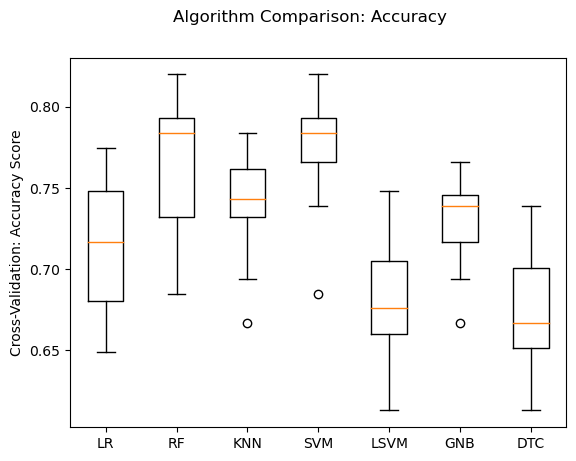


LR = LogisticRegression
RF = RandomForestClassifier
KNN = KNeighborsClassifier
SVM = Support Vector Machine SVC
LSVM = LinearSVC
GNB = GaussianNB
DTC = DecisionTreeClassifier



In [30]:
compareABunchOfDifferentModelsAccuracy(X_trainFlat, y_train, X_testFlat, y_test)

<font color='#32a852'>SVM has best performance. </font>

## Final Model: SVM

In [37]:
def classification(model, X_train, y_train, X_test, y_test, threshold):
    
    
    # Record score from cross cross-validation run
    cv_results = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
   
    print("Accuracy for Cross validation results: %s" % ["{0:.3f}"\
        .format(i) for i in cv_results])
    
    #print(f"Log loss for cross validation results: {i: .3f}" for i in cv_results)
    
    print("Mean accuracy for Cross validation results: %s" % "{0:.3f}"\
        .format(cv_results.mean()))

    print("STD of accuracy for Cross validation results: %s" % "{0:.3f}"\
        .format(cv_results.std()))   
    
    
    # Fit the model:
    model.fit(X_train, y_train)
    
    
    # Print fraction of correct predictions on test data set:
    print("Accuracy on test data set: %s\n" % "{0:.3f}".format(accuracy_score(y_test\
        , model.predict(X_test))))
                                                                                     
    
    # Make predictions on testing set:
    predicted_proba_test = model.predict_proba(X_test)
    y_test_pred = (predicted_proba_test[:,1] >= threshold).astype('int')
    
    
    # Print Classification report and Confusion_matrix
    cm = confusion_matrix(y_test, y_test_pred)
    cm_normalized = confusion_matrix(y_test, y_test_pred, normalize='true')
    
    # Non-Normalized Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[0, 1]
                                  #display_labels=model.classes_
                                 )
    
    disp.plot()
    plt.show()

    # Normalized Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized
                                  , display_labels=[0, 1]
                                  #display_labels=model.classes_
                                 )
    
    disp.plot()
    plt.show()
    
    
    print('\n')
    print('Classification Report')
    print(classification_report(y_test, y_test_pred))

In [38]:
model_svm = SVC(probability=True)

Accuracy for Cross validation results: ['0.788', '0.752', '0.788', '0.773', '0.750', '0.748', '0.784', '0.770', '0.743', '0.819']
Mean accuracy for Cross validation results: 0.771
STD of accuracy for Cross validation results: 0.023
Accuracy on test data set: 0.794



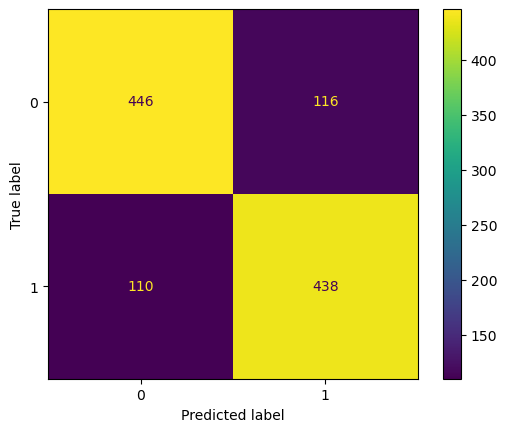

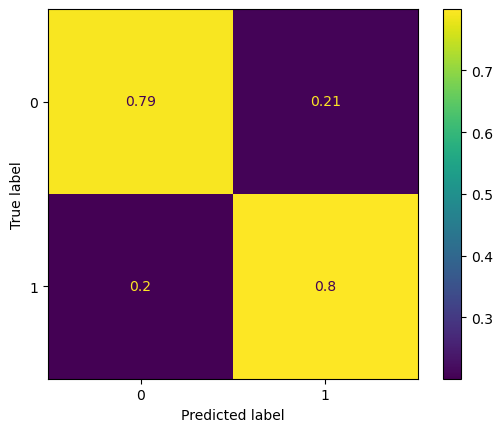



Classification Report
              precision    recall  f1-score   support

           0       0.80      0.79      0.80       562
           1       0.79      0.80      0.79       548

    accuracy                           0.80      1110
   macro avg       0.80      0.80      0.80      1110
weighted avg       0.80      0.80      0.80      1110



In [39]:
classification(model_svm, X_trainFlat, y_train, X_testFlat, y_test, 0.5)

In [40]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Plots a learning curve. http://scikit-learn.org/stable/modules/learning_curve.html
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt


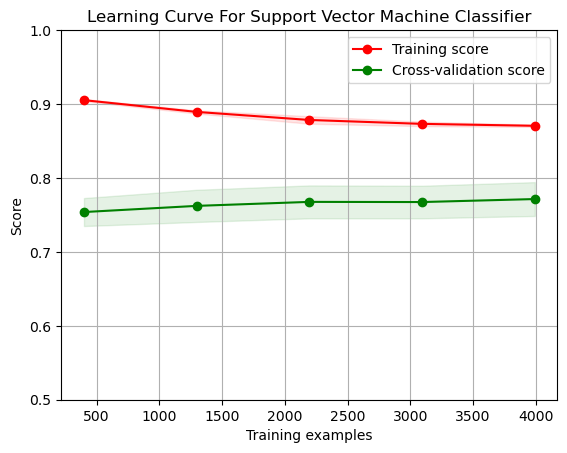

In [41]:
def plotLotsOfLearningCurves(a,b):
    """Plot a bunch of learning curves http://scikit-learn.org/stable/modules/learning_curve.html"""
    models = []
    models.append(('Support Vector Machine', SVC()))
    for name, model in models:
        plot_learning_curve(model, 'Learning Curve For %s Classifier'% (name), a,b, (0.5,1), 10)
plotLotsOfLearningCurves(X_trainFlat, y_train)